# import library

In [213]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(R.utils)
library(AnnotationDbi)
library(sva)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(GGally)
library(ChIPpeakAnno)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(Seurat)
library(kableExtra)
library(tidyverse)
library(ggraph)
library(tidygraph)
library(clusterProfiler)
library(enrichplot)
library(readxl)
library(umap)
library(corrplot)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(tidyverse)
library(maSigPro)
library(RSQLite)
library(glue)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


In [17]:
dir.create(data_dir)

In [167]:
data_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/DBA/'
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/Macraphge_Monocyte_DC/' 
setwd(data_dir)
source('~/script/utils.r')



# import design table

In [72]:
# GSE119954 
# 9 individuals with DBA with putative splice mutations and 5 control individuals were processed for RNA-seq.

dsn_gse119954_string = glue(
    'GSM3389330	Control LCL 1	control1
GSM3389331	Control LCL 2	control2
GSM3389332	Control LCL 3	control3
GSM3389333	Control LCL 4	control4
GSM3389334	Control LCL 5	control5
GSM3389335	DBA splice mutant LCL 1	dba1
GSM3389336	DBA splice mutant LCL 2	dba2
GSM3389337	DBA splice mutant LCL 3	dba3
GSM3389338	DBA splice mutant LCL 4	dba4
GSM3389339	DBA splice mutant LCL 5	dba5
GSM3389340	DBA splice mutant LCL 6	dba6
GSM3389341	DBA splice mutant LCL 7	dba7
GSM3389342	DBA splice mutant LCL 8	dba8
GSM3389343	DBA splice mutant LCL 9	dba9')



In [73]:
# GSE181830
# Directional paired-end bulk RNAseq of CD34-Lin-CD71+GYPA+ erythroblasts FACS-isolated from human bone marrow from healthy controls (n=3) and patients with Diamond- Blackfan anemia (n=3 transfusion-dependent; n=1 transfusion independent and n=1 steroid-dependent)

dsn_gse181830_string = glue(
'GSM5534068	Con1	control6
GSM5534069	Con2	control7
GSM5534070	Con3	control8
GSM5534071	DBA1	dba10
GSM5534072	DBA2	dba11
GSM5534073	DBA3	dba12
GSM5534074	DBA4	dba13
GSM5534075	DBA5	dba14')


In [180]:
tmp1 = fread(text = dsn_gse119954_string, sep = '\t', header = F)
tmp2 = fread(text = dsn_gse181830_string, sep = '\t', header = F)
dsn_list = list(tmp1, tmp2)
names(dsn_list) = c('GSE119954', 'GSE181830')
dsn_dt = rbindlist(dsn_list, idcol = T)
setnames(dsn_dt, c('.id', 'gsm_id', 'assay_sample_desc', 'assay_sample_name'))
dsn_dt

.id,gsm_id,assay_sample_desc,assay_sample_name
<chr>,<chr>,<chr>,<chr>
GSE119954,GSM3389330,Control LCL 1,control1
GSE119954,GSM3389331,Control LCL 2,control2
GSE119954,GSM3389332,Control LCL 3,control3
GSE119954,GSM3389333,Control LCL 4,control4
GSE119954,GSM3389334,Control LCL 5,control5
GSE119954,GSM3389335,DBA splice mutant LCL 1,dba1
GSE119954,GSM3389336,DBA splice mutant LCL 2,dba2
GSE119954,GSM3389337,DBA splice mutant LCL 3,dba3
GSE119954,GSM3389338,DBA splice mutant LCL 4,dba4


dsn_string = list(tmp1, tmp2)
dsn_list = lapply(dsn_string, function(xx){
    dsn_dt = fread(text = xx, sep = '\t', header = F)
    dsn_dt = as.data.table(dsn_dt)
    dsn_dt = setnames(dsn_dt, c('gsm_id', 'assay_sample_desc', 'assay_sample_name'))
    dsn_dt
})
names(dsn_list) = c('GSE119954', 'GSE181830')
dsn_dt = rbindlist(dsn_list, idcol = T)


In [194]:
# find SRR ID
#dsn_dt[, cmd := paste0('echo "', gsm_id, '\n" && ', '~/edirect/esearch -db sra -query "', gsm_id)] 
dsn_dt[, cmd := paste0(' echo ', gsm_id, ' & echo "\t" && ~/edirect/esearch -db sra -query "', gsm_id)] 
dsn_dt[, cmd := paste0(cmd, '" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "\n" "," && echo "\n"')]
#dsn_dt[, srr_id := {system(cmd, intern = T)}, by = 1:nrow(dsn_dt)]
write(dsn_dt[, cmd], file = 'runid2.sh')
# run in the terminal 


In [195]:
dsn_dt[15, cmd]

[1] " echo GSM5534068 & echo \"\t\" && ~/edirect/esearch -db sra -query \"GSM5534068\" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr \"\n\" \",\" && echo \"\n\""

In [196]:
srr_string = glue('GSM3389330 SRR7828379 
GSM3389331 SRR7828380
GSM3389332 SRR7828381
GSM3389333 SRR7828382
GSM3389334 SRR7828383
GSM3389335 SRR7828384
GSM3389336 SRR7828385
GSM3389337 SRR7828386
GSM3389338 SRR7828387
GSM3389339 SRR7828388
GSM3389340 SRR7828389
GSM3389341 SRR7828390
GSM3389342 SRR7828391
GSM3389343 SRR7828392
GSM5534068 SRR15594007
GSM5534069 SRR15594008
GSM5534070 SRR15594009
GSM5534071 SRR15594010
GSM5534072 SRR15594011
GSM5534073 SRR15594012
GSM5534074 SRR15594013
GSM5534075 SRR15594014')
srr_dt = fread(text = srr_string, sep = ' ', header = F)


In [197]:
srr_dt

V1,V2
<chr>,<chr>
GSM3389330,SRR7828379
GSM3389331,SRR7828380
GSM3389332,SRR7828381
GSM3389333,SRR7828382
GSM3389334,SRR7828383
GSM3389335,SRR7828384
GSM3389336,SRR7828385
GSM3389337,SRR7828386
GSM3389338,SRR7828387


In [198]:
dsn_dt2 = merge(dsn_dt, srr_dt, by.x = 'gsm_id', by.y = 'V1')
setnames(dsn_dt2, 'V2', 'srr_id')
head(dsn_dt2)


gsm_id,.id,assay_sample_desc,assay_sample_name,cmd,srr_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM3389330,GSE119954,Control LCL 1,control1,"echo GSM3389330 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389330"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828379
GSM3389331,GSE119954,Control LCL 2,control2,"echo GSM3389331 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389331"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828380
GSM3389332,GSE119954,Control LCL 3,control3,"echo GSM3389332 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389332"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828381
GSM3389333,GSE119954,Control LCL 4,control4,"echo GSM3389333 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389333"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828382
GSM3389334,GSE119954,Control LCL 5,control5,"echo GSM3389334 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389334"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828383
GSM3389335,GSE119954,DBA splice mutant LCL 1,dba1,"echo GSM3389335 & echo "" "" && ~/edirect/esearch -db sra -query ""GSM3389335"" | ~/edirect/efetch -format docsum | ~/edirect/accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "" "" "","" && echo "" """,SRR7828384


In [199]:
dsn_dt2[, assay_sample_dir := paste0(data_dir, assay_sample_name, '/')]

In [ ]:
inv = dsn_dt2[, {dir.create(assay_sample_dir, showWarnings = T, recursive = F)}, by = 1:nrow(dsn_dt2)] 
all(inv)

In [201]:
dsn_dt2[, prefetch_cmd := paste0('prefetch ',     srr_id, ' -O ', assay_sample_dir, ' --max-size 40g')]
dsn_dt2[, fastqdump_cmd:= paste0('cd ', assay_sample_dir, ' && fasterq-dump ', srr_id, ' --outdir ', assay_sample_dir, ' & ')]

# if single end seq
dsn_dt2[, dump_r := paste0(assay_sample_dir,  '/', srr_id, '.fastq')]
# if double end seq
dsn_dt2[, dump_r1 := paste0(assay_sample_dir, '/', srr_id, '_1.fastq')] 
dsn_dt2[, dump_r2 := paste0(assay_sample_dir, '/', srr_id, '_2.fastq')]

dsn_dt2[, gz_r_cmd := paste0(' gzip ', dump_r, ' &' )]
dsn_dt2[, gz_r1_cmd := paste0(' gzip ', dump_r1, ' &' )]
dsn_dt2[, gz_r2_cmd := paste0(' gzip ', dump_r2, ' &' )]

dsn_dt2[, r_fastq_gz := paste0(dump_r, '.gz')]
dsn_dt2[, r1_fastq_gz := paste0(dump_r1, '.gz')]
dsn_dt2[, r2_fastq_gz := paste0(dump_r2, '.gz')]


In [202]:
# run under ~/conda3/envs/te env
# requres the new version prefetch
write(dsn_dt2[, prefetch_cmd],  file = 'run_fastq_prefetch.sh')
write(dsn_dt2[, fastqdump_cmd], file = 'run_fastq_dump.sh')
write(dsn_dt2[, gz_r1_cmd], file = 'run_gzip.sh', append = F)
write(dsn_dt2[, gz_r2_cmd], file = 'run_gzip.sh', append = T)


# cutadapt

In [203]:
# module load cutadapt/4.4
dsn_dt2[, fastq_r1_trimmed := paste0(assay_sample_dir, assay_sample_name, '_R1_trimmed.fa.gz')]
dsn_dt2[, fastq_r2_trimmed := paste0(assay_sample_dir, assay_sample_name, '_R2_trimmed.fa.gz')]
dsn_dt2[, cutadapt_jobname := paste0('cuta_', assay_sample_name)]
dsn_dt2[, cutadapt_oo := paste0(assay_sample_dir, cutadapt_jobname, '_out')]
dsn_dt2[, cutadapt_eo := paste0(assay_sample_dir, cutadapt_jobname, '_err')]
dsn_dt2[, cutadapt_cmd := paste0('bsub -J ', cutadapt_jobname, ' -n 3 -o ', cutadapt_oo, ' -e ', cutadapt_eo)]
dsn_dt2[, cutadapt_cmd := paste0(cutadapt_cmd, ' " cutadapt -o ', fastq_r1_trimmed, ' -p ', fastq_r2_trimmed, ' ', r1_fastq_gz, ' ', r2_fastq_gz, '"')]
write(dsn_dt2[, cutadapt_cmd], file = paste0(data_dir, 'run_cutadapt.sh'))


# alignment

In [204]:
# module load star/2.7.10a
REFERENCE_GENOME="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Data_Public/RNA_seq/Demthylation_therapy_AML_cell_lines_RNA-seq_Khawanky_etal_Nature_communicat_GSE184891/trimmed_fastq/STAR_normal_mapped_t2t/TE_locus_analysis"

dsn_dt2[, star_jobname := paste0('star_', assay_sample_name)]
dsn_dt2[, star_oo := paste0(assay_sample_dir, 'star_', assay_sample_name, '_out')]
dsn_dt2[, star_eo := paste0(assay_sample_dir, 'star_', assay_sample_name, '_err')]
dsn_dt2[, bam_prefix := paste0(assay_sample_dir, assay_sample_name, '_')]
dsn_dt2[, bam_file := paste0(bam_prefix, 'Aligned.sortedByCoord.out.bam')]
dsn_dt2[, bam_tx_file := paste0(bam_prefix, 'Aligned.toTranscriptome.out.bam')]
#alignments/A549_0_1 Aligned.sortedByCoord.out.bam

dsn_dt2[, star_cmd := paste0('bsub -J ', star_jobname, ' -o ', star_oo, ' -e ', star_eo, ' -P macmon -n 25 -R "rusage[mem=5GB]" ')]
#dsn_dt2[, star_cmd := paste0(star_cmd, ' -w ', cutadapt_jobname)]
dsn_dt2[, star_cmd := paste0(star_cmd, ' -W 290')]
dsn_dt2[, star_cmd := paste0(star_cmd, ' " STAR --genomeDir ', REFERENCE_GENOME)] 
dsn_dt2[, star_cmd := paste0(star_cmd, ' --runThreadN 28 --outSAMtype BAM SortedByCoordinate --outFilterMultimapNmax 1000 --outSAMmultNmax 1 ')]
dsn_dt2[, star_cmd := paste0(star_cmd, ' --outFilterMismatchNmax 3 --outMultimapperOrder Random --winAnchorMultimapNmax 1000 --alignEndsType EndToEnd ')]
dsn_dt2[, star_cmd := paste0(star_cmd, ' --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn ', fastq_r1_trimmed, ' ', fastq_r2_trimmed, ' ')]
#dsn_dt2[, star_cmd := paste0(star_cmd, ' --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn ', fastq_r1_trimmed, ' ', fastq_r2_trimmed, ' ')]
dsn_dt2[, star_cmd := paste0(star_cmd, ' --readFilesCommand zcat --outFileNamePrefix ', bam_prefix, '"')]

write(dsn_dt2[, star_cmd], file = paste0(data_dir, 'run_star.sh'))

#STAR --genomeDir $REFERENCE_GENOME \
#                --runThreadN 28 --outSAMtype BAM SortedByCoordinate --outFilterMultimapNmax 1000 --outSAMmultNmax 1 \
#                --outFilterMismatchNmax 3 --outMultimapperOrder Random --winAnchorMultimapNmax 1000 --alignEndsType EndToEnd \
#                --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn "$R1_FILE" "$R2_FILE" --readFilesCommand zcat \
#                --outFileNamePrefix "$OUTPUT_DIR/${SAMPLE_NAME}_"

In [205]:
file.exists(dsn_dt2$bam_file)

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

# TEcount

In [206]:
dsn_dt2[, telocal_file := paste0(assay_sample_dir, 'telocal.cntTable') ]
dsn_dt2[, tecount_file := paste0(assay_sample_dir, 'tecount.cntTable') ]
file.exists(dsn_dt2$telocal_file)
file.exists(dsn_dt2$tecount_file)


[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

In [207]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
bin_tecount = '/home/whu78/conda3/envs/te/bin/'

dsn_dt2[, tecount_jobname := paste0('tecount_', assay_sample_name)]
dsn_dt2[, tecount_oo := paste0(assay_sample_dir, 'tecount_', assay_sample_name, '_out')]
dsn_dt2[, tecount_eo := paste0(assay_sample_dir, 'tecount_', assay_sample_name, '_err')]

dsn_dt2[, tecount_cmd := paste0('bsub -J ', tecount_jobname, ' -n 10 -o ', tecount_oo, ' -e ', tecount_eo, ' -P macmon -R "rusage[mem=5GB]" ')]
dsn_dt2[, tecount_cmd := paste0(tecount_cmd, ' -W 99:00')]
dsn_dt2[, tecount_cmd := paste0(tecount_cmd, ' " cd ', assay_sample_dir, ' && ', bin_tecount, 'TEcount --sortByPos --format BAM --mode multi -b ', bam_file)] 
dsn_dt2[, tecount_cmd := paste0(tecount_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_GTF_FILE, ' --project tecount "')] 

#write(dsn_dt2[count_file == 'Yes', tecount_cmd], file = paste0(base_dir, 'run_tecount.sh'))
write(dsn_dt2[, tecount_cmd], file = paste0(data_dir, 'run_tecount.sh'))


In [208]:
dsn_dt2$assay_sample_name

[1] "control1" "control2" "control3" "control4" "control5" "dba1"    
 [7] "dba2"     "dba3"     "dba4"     "dba5"     "dba6"     "dba7"    
[13] "dba8"     "dba9"     "control6" "control7" "control8" "dba10"   
[19] "dba11"    "dba12"    "dba13"    "dba14"

# TElocal

In [209]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
#TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
#TE_loc_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/T2T-CHM13_v2_rmsk_TE.gtf.locInd"
#TE_loc_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/data/T2T_CHM13_v2_rmsk_TE.gtf.locInd"

TE_GTF_FILE = '/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf'
TE_loc_GTF_FILE = '/research/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/T2T_CHM13_v2_rmsk_TE.gtf.locInd'

sif_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/images/telocal.sif'
bin_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/conda3/envs/snap/bin/'
exe_telocal = '/home/whu78/repos/TElocal/TElocal'
exe_telocal = '/home/whu78/conda3/envs/te/bin/TElocal'

dsn_dt2[, telocal_jobname := paste0('telocal_', assay_sample_name)]
dsn_dt2[, telocal_oo := paste0(assay_sample_dir, 'telocal_', assay_sample_name, '_out')]
dsn_dt2[, telocal_eo := paste0(assay_sample_dir, 'telocal_', assay_sample_name, '_err')]

dsn_dt2[, telocal_cmd := paste0('bsub -J ', telocal_jobname, ' -n 10 -o ', telocal_oo, ' -e ', telocal_eo, ' -P macmon -R "rusage[mem=5GB]" ')]
dsn_dt2[, telocal_cmd := paste0(telocal_cmd, ' -W 99:00')]
dsn_dt2[, telocal_cmd := paste0(telocal_cmd, ' " cd ', assay_sample_dir, ' && ', exe_telocal, ' --sortByPos -b ', bam_file)] 
dsn_dt2[, telocal_cmd := paste0(telocal_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_loc_GTF_FILE, ' --stranded reverse --project telocal "')] 
#dsn_dt2[, telocal_cmd := paste0(telocal_cmd, ' --outdir ', telocal_dir)]

write(dsn_dt2[, telocal_cmd], file = paste0(data_dir, 'run_telocal.sh'))


# import TEcount

In [216]:
coding_genes = read.table('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/coding_gene_list', header = F)$V1
te_genes = read.table('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/te_gene_list', header = F)$V1

tecount_list = lapply(dsn_dt2$tecount_file, function(xx){
    tmp = fread(xx)
    setnames(tmp, c('gene', 'count'))
})

names(tecount_list) = dsn_dt2$assay_sample_name
tecount_dt = rbindlist(tecount_list, idcol = T) 
tecount_dt = dcast(gene ~ .id, value.var = 'count', data = tecount_dt)

tecount_df = setDF(tecount_dt[, 2:ncol(tecount_dt)], rownames = tecount_dt$gene)


In [219]:
tecount_combat_df = ComBat_seq(as.matrix(tecount_df), batch = dsn_dt2$.id)
head(tecount_combat_df)

Found 2 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


,control1,control2,control3,control4,control5,control6,control7,control8,dba1,dba10,⋯,dba13,dba14,dba2,dba3,dba4,dba5,dba6,dba7,dba8,dba9
(CATTC)n:Satellite:Satellite,7,11,1,5,0,7,5,41,16,66,⋯,123,20,42,2,13,9,2,1,10,2
(GAATG)n:Satellite:Satellite,14,29,11,12,9,20,18,104,29,142,⋯,273,66,115,9,24,6,8,8,11,16
7SLRNA:srpRNA:srpRNA,4,4,4,9,10,4,7,4,1,8,⋯,0,0,1,2,1,2,0,3,7,2
A-rich:Low_complexity:Low_complexity,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A1BG,15,76,83,74,95,39,39,16,134,26,⋯,28,16,19,10,16,40,2,32,12,67
A1BG-AS1,54,136,99,83,130,73,65,31,135,22,⋯,39,32,78,23,97,6,6,53,15,33


In [220]:
write.table(tecount_combat_df, file = 'tecount_combat_df.tsv') 


# normalized reads & coding/TE DEG

In [222]:
dsn_dt2[, group := 'Control']
dsn_dt2[grep('dba', assay_sample_name), group := 'DBA']
head(dsn_dt2[, .(assay_sample_name, group)])

assay_sample_name,group
<chr>,<chr>
control1,Control
control2,Control
control3,Control
control4,Control
control5,Control
dba1,DBA


In [223]:
head(tecount_dt)

gene,control1,control2,control3,control4,control5,control6,control7,control8,dba1,⋯,dba13,dba14,dba2,dba3,dba4,dba5,dba6,dba7,dba8,dba9
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
(CATTC)n:Satellite:Satellite,5,9,1,3,0,4,3,36,14,⋯,118,16,47,2,16,11,3,1,12,2
(GAATG)n:Satellite:Satellite,9,23,7,7,5,10,9,96,23,⋯,282,55,114,15,32,10,14,12,16,21
7SLRNA:srpRNA:srpRNA,2,2,2,6,7,2,4,2,1,⋯,0,0,2,3,2,4,0,4,10,3
A-rich:Low_complexity:Low_complexity,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A1BG,5,54,60,51,70,12,12,4,111,⋯,9,4,59,42,53,70,22,58,38,90
A1BG-AS1,30,112,73,56,103,27,23,10,112,⋯,13,10,123,71,134,37,46,77,50,64


In [231]:
# take all together for logcpm
subtype = factor(dsn_dt2$group)
subtype = relevel(subtype, ref = 'Control')

dge = DGEList(counts = tecount_combat_df[coding_genes, ], group = subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~  subtype)
dge = estimateDisp(dge, design)
et <- exactTest(dge)
deg = topTags(et, n = length(keep))
deg_coding_dt = as.data.table(deg$table, keep.rownames = T)

logcpm_coding_df = log1p(cpm(dge, normalize = T))

logcpm_coding_dt = merge(as.data.table(t(logcpm_coding_df), keep.rownames = T), dsn_dt2[, .(assay_sample_name, group)], by.x = 'rn', by.y = 'assay_sample_name', all.x = T)
head(logcpm_coding_dt)


rn,A1BG,A1BG-AS1,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,⋯,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
control1,0.6836467,1.511146,0.96893952,2.587487,3.817186,4.144249,5.063673,3.989803,2.349837,⋯,5.660919,1.0407594,1.567270,2.071035,2.223666,2.672328,3.651775,3.532992,4.257842,Control
control2,1.8825584,2.394972,0.70611600,2.865868,3.838201,4.004978,5.183859,4.074625,2.502573,⋯,5.465292,1.0666490,1.738846,2.017979,1.904624,2.560850,3.547170,3.479480,4.476494,Control
control3,1.9411760,2.093984,0.94840871,3.397862,3.775774,4.070471,5.025579,3.996638,2.460591,⋯,5.787174,1.1495351,1.696942,2.102802,2.315515,2.565393,3.348580,3.460760,4.170799,Control
control4,1.7824977,1.878864,0.47086622,3.024236,3.906243,4.247900,4.898129,4.276151,2.435711,⋯,5.609806,1.2448296,2.003468,1.985280,1.318985,2.753687,3.223746,3.650296,4.513865,Control
control5,2.0494497,2.327813,1.64876801,2.583675,3.712132,4.155674,4.732967,4.081570,2.368623,⋯,5.052551,0.8555745,1.532773,2.067624,2.646180,2.705008,3.260441,3.499818,4.393871,Control
control6,0.7257673,1.097253,0.02697433,3.783752,4.690332,2.695129,4.237245,3.098391,2.774948,⋯,5.482311,1.3881820,2.500013,3.914671,0.000000,3.867776,1.557255,4.567595,3.989769,Control


In [227]:
head( tecount_df[!rownames(tecount_df) %in% coding_genes, ])

,control1,control2,control3,control4,control5,control6,control7,control8,dba1,dba10,⋯,dba13,dba14,dba2,dba3,dba4,dba5,dba6,dba7,dba8,dba9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
(CATTC)n:Satellite:Satellite,5,9,1,3,0,4,3,36,14,60,⋯,118,16,47,2,16,11,3,1,12,2
(GAATG)n:Satellite:Satellite,9,23,7,7,5,10,9,96,23,134,⋯,282,55,114,15,32,10,14,12,16,21
7SLRNA:srpRNA:srpRNA,2,2,2,6,7,2,4,2,1,5,⋯,0,0,2,3,2,4,0,4,10,3
A-rich:Low_complexity:Low_complexity,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ACRO1:acro:Satellite,1,1,3,5,2,19,23,10,0,19,⋯,12,5,5,1,3,7,0,2,7,3
ALR/Alpha:centr:Satellite,164,183,172,312,297,241,314,1028,265,1211,⋯,2740,746,188,215,121,332,142,202,416,451


In [237]:
dsn_dt2[, .(.id, assay_sample_name, group)]

.id,assay_sample_name,group
<chr>,<chr>,<chr>
GSE119954,control1,Control
GSE119954,control2,Control
GSE119954,control3,Control
GSE119954,control4,Control
GSE119954,control5,Control
GSE119954,dba1,DBA
GSE119954,dba2,DBA
GSE119954,dba3,DBA
GSE119954,dba4,DBA


In [313]:
# take all together for logcpm
tmp = dsn_dt2[.id == 'GSE119954', ]
subtype = factor(tmp$group)
subtype = relevel(subtype, ref = 'Control')

dge = DGEList(counts = tecount_combat_df[!rownames(tecount_df) %in% coding_genes, tmp$assay_sample_name], group = subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~  subtype)
dge = estimateDisp(dge, design)
et <- exactTest(dge)
deg = topTags(et, n = length(keep))
deg_te_dt_b1 = as.data.table(deg$table, keep.rownames = T)

logcpm_te_df_b1 = log1p(cpm(dge, normalize = T))


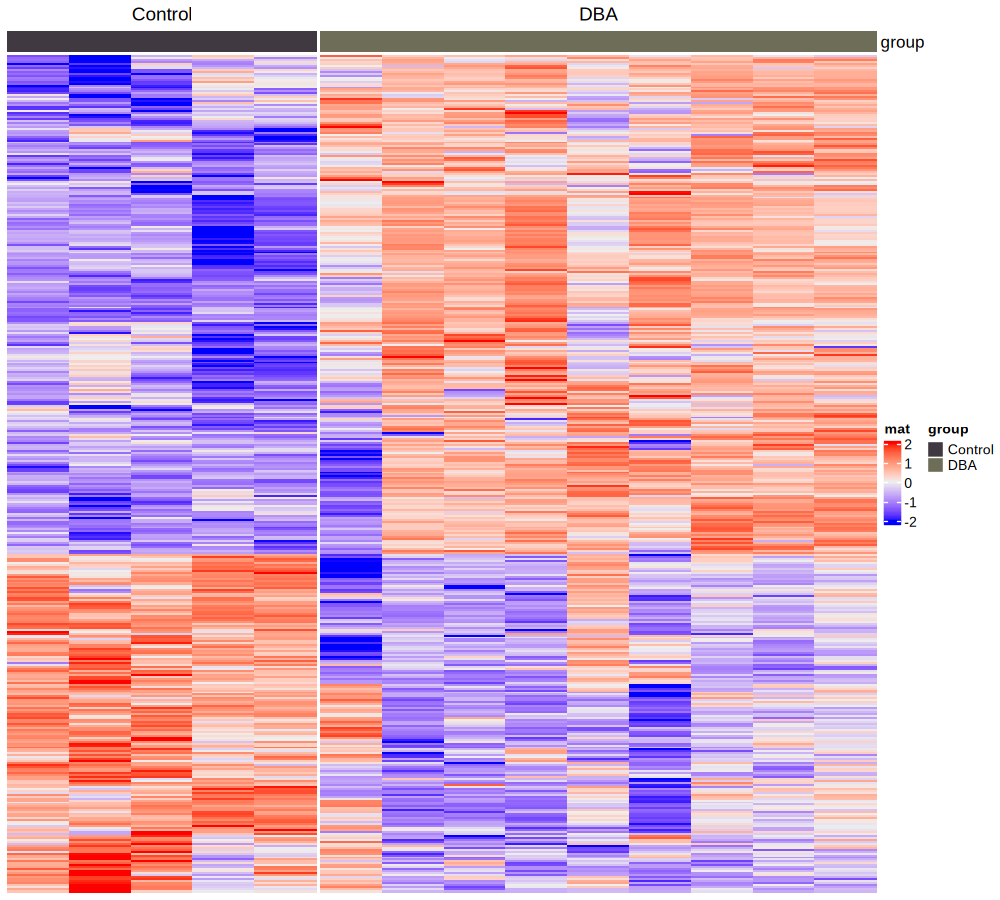

In [314]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt_b1[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = deg_te_dt_b1[FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[rn %in% cmp$rn, cmp := 'CMP']

plotdat = logcpm_te_df_b1[row_sel$rn, tmp$assay_sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = tmp[, 'group', drop = F])
#column_ra = rowAnnotation(df = row_sel[, cmp, drop = F]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha,# left_annotation = column_ra, 
        column_split = factor(tmp$group, levels = c('Control', 'DBA')))  

In [322]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/DBA"

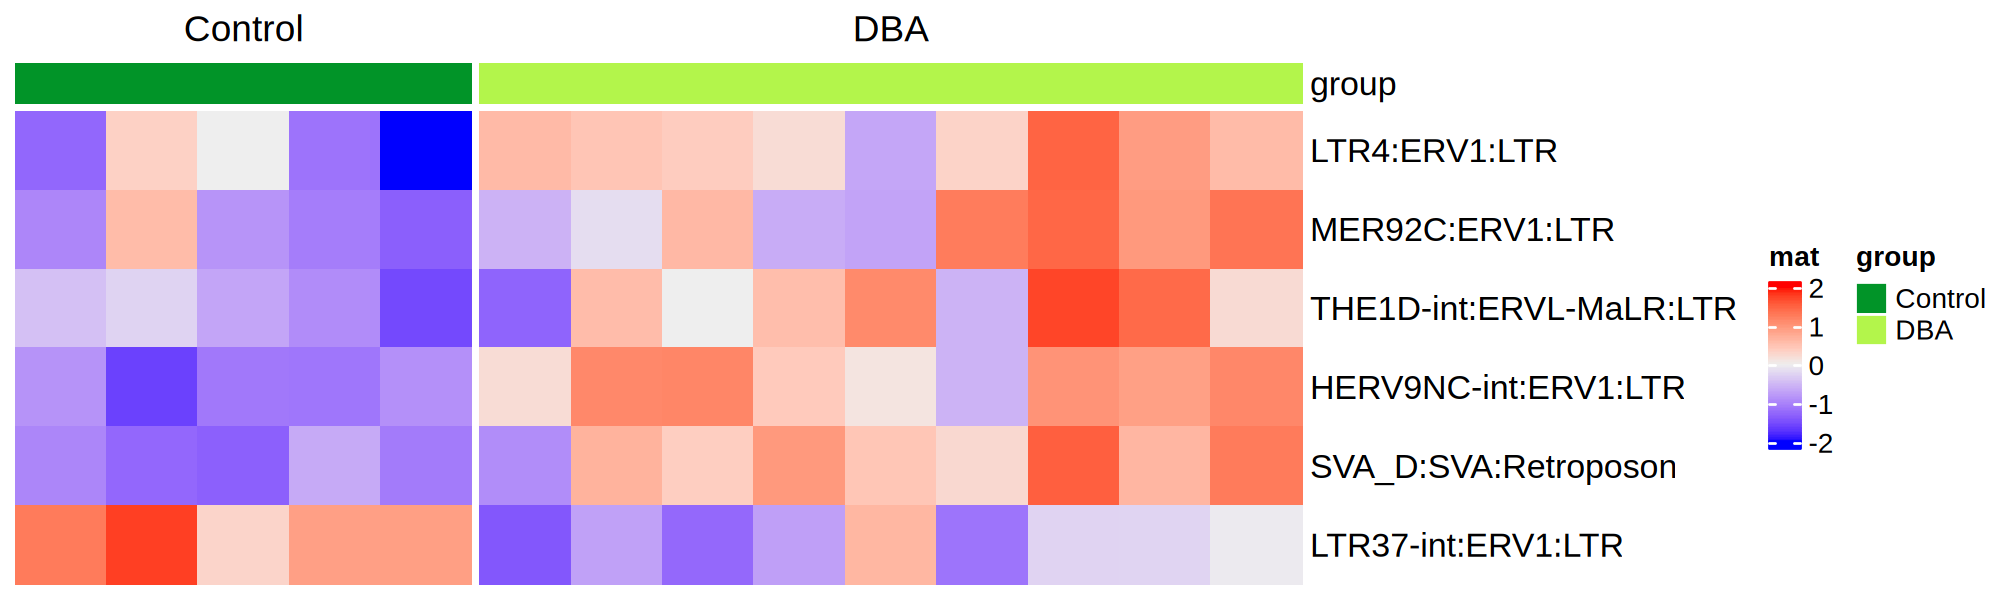

In [323]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
# from nb_TE_blueprint_HSPC_2024May29.ipynb
# MEP/EB/MK related TEs
cmp = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/row_sel.tsv')
row_sel = deg_te_dt_b1[abs(logFC) > .6 & FDR < 0.1, ]
#row_sel = deg_te_dt_b1[FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel = row_sel[rn %in% cmp$rn,]
write.table(row_sel, file = 'dba_row_sel.tsv')

plotdat = logcpm_te_df_b1[row_sel$rn, tmp$assay_sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = tmp[, 'group', drop = F])
#column_ra = rowAnnotation(df = row_sel[, cmp, drop = F]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha,# left_annotation = column_ra, 
        column_split = factor(tmp$group, levels = c('Control', 'DBA')))  

In [319]:
row_sel

rn,logFC,logCPM,PValue,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MER92C:ERV1:LTR,1.140959,4.174714,0.009767492,0.03413911


In [317]:
plotdat

control1 control2 control3 control4 control5     dba1     dba2     dba3 
2.188706 3.092248 2.262433 2.138641 1.974734 2.429630 2.664209 3.113605 
    dba4     dba5     dba6     dba7     dba8     dba9 
2.397469 2.347576 3.490791 3.607864 3.316064 3.535120

In [324]:
# take all together for logcpm
tmp = dsn_dt2[.id == 'GSE181830', ]
subtype = factor(tmp$group)
subtype = relevel(subtype, ref = 'Control')

dge = DGEList(counts = tecount_combat_df[!rownames(tecount_df) %in% coding_genes, tmp$assay_sample_name], group = subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~  subtype)
dge = estimateDisp(dge, design)
et <- exactTest(dge)
deg = topTags(et, n = length(keep))
deg_te_dt_b2 = as.data.table(deg$table, keep.rownames = T)

logcpm_te_df_b2 = log1p(cpm(dge, normalize = T))


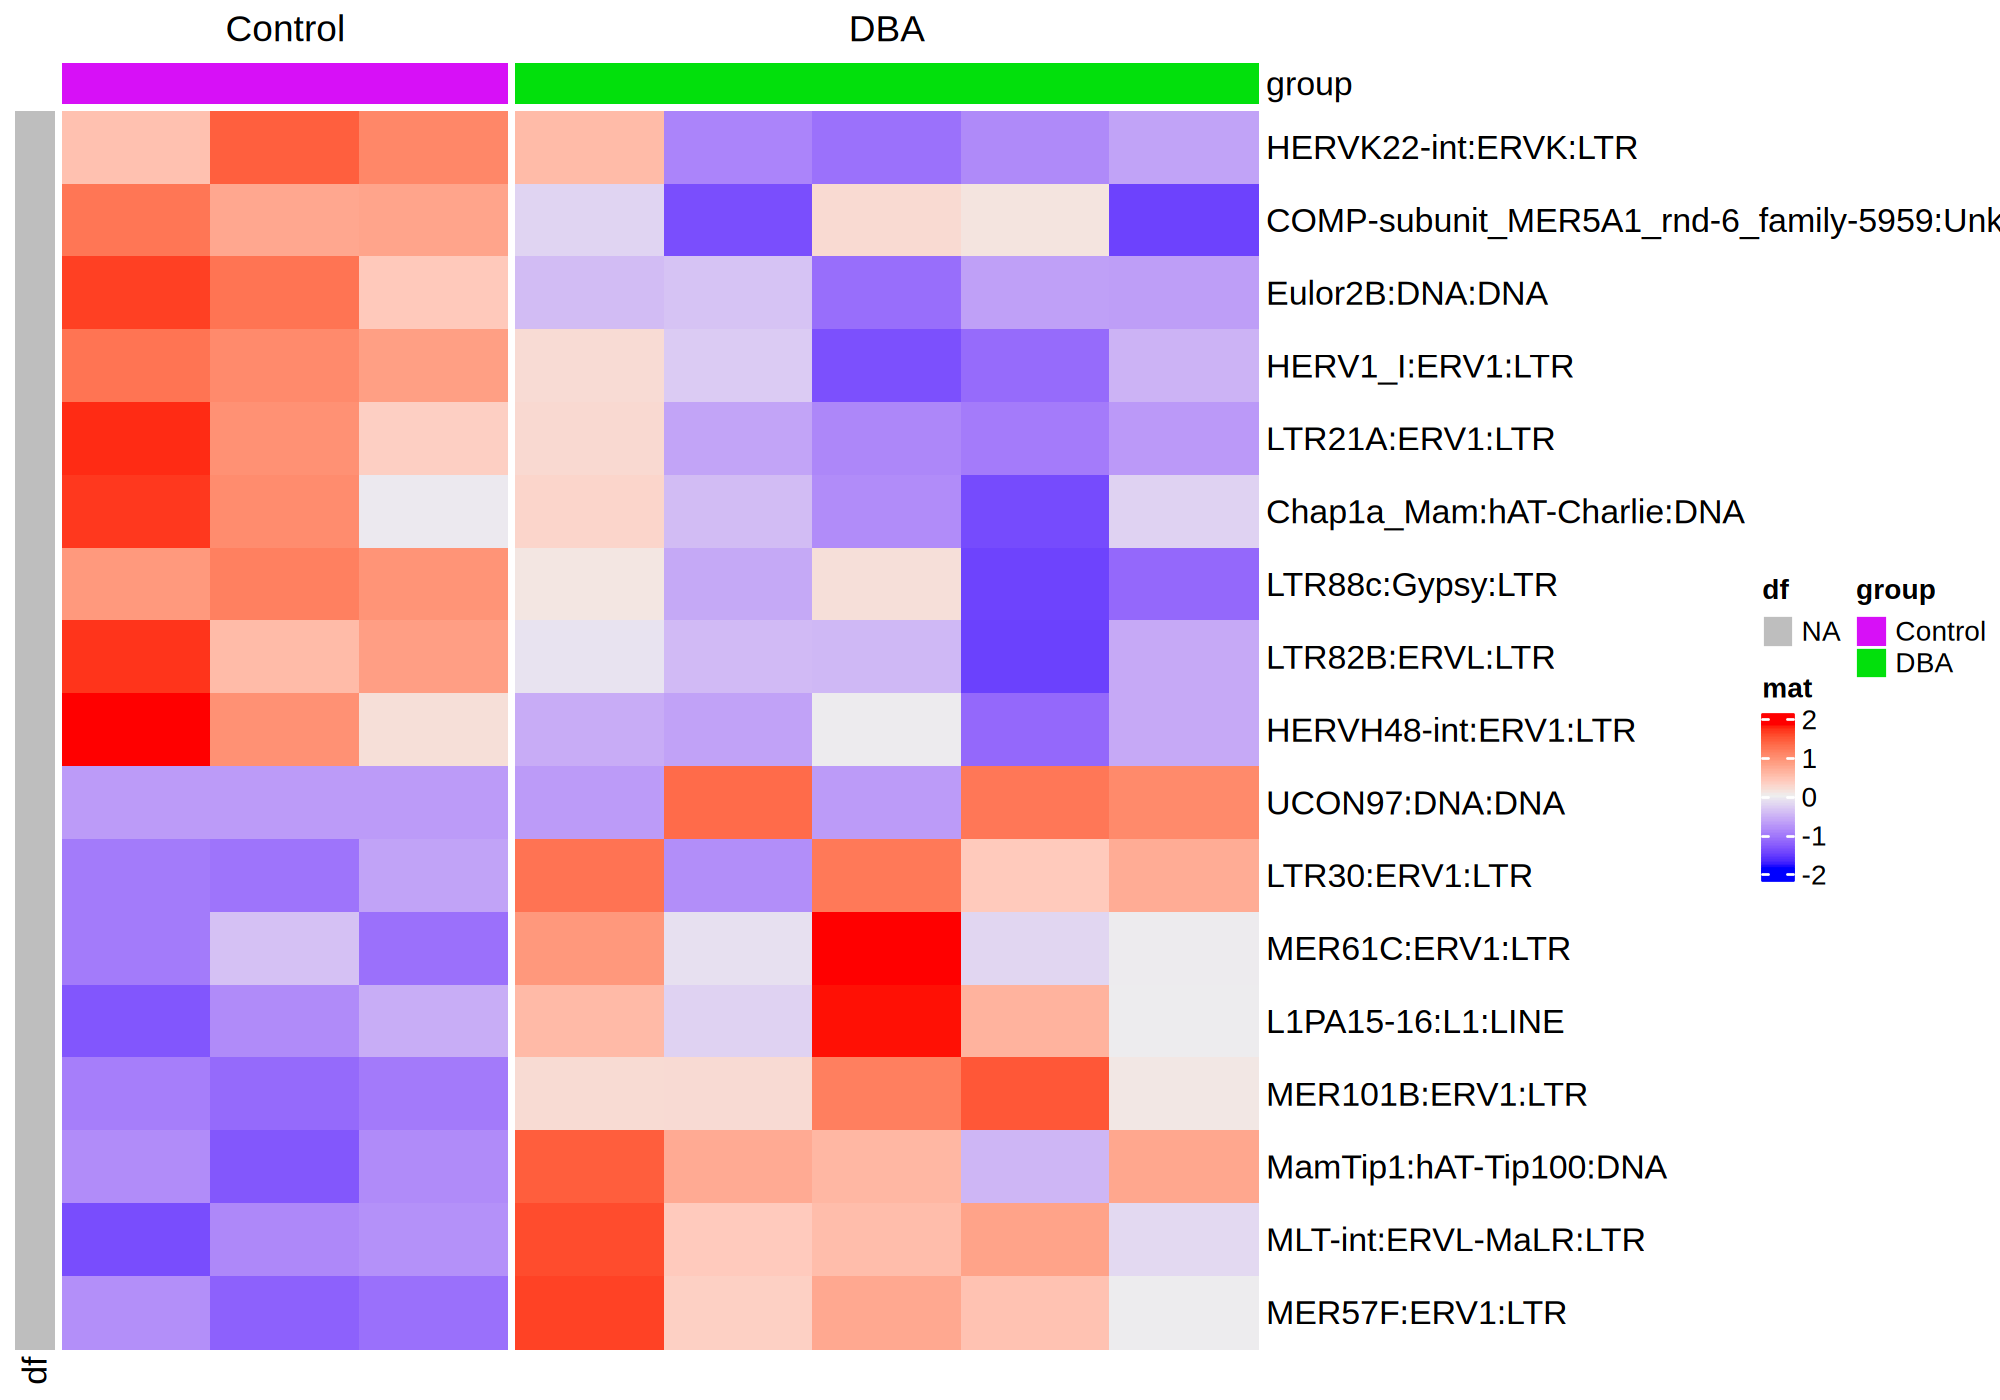

In [325]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
cmp = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/row_sel.tsv')
row_sel = deg_te_dt_b2[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[rn %in% cmp$rn, cmp := 'CMP']

plotdat = logcpm_te_df_b2[row_sel$rn, tmp$assay_sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = tmp[, 'group', drop = F])
column_ra = rowAnnotation(df = row_sel[, cmp, drop = F]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(tmp$group, levels = c('Control', 'DBA')))  


In [327]:
intersect(rownames(plotdat), cmp$rn)

character(0)

In [ ]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)

row_sel = deg_te_dt_b2[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = deg_te_dt_b2[FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel = row_sel[rn %in% cmp$rn,]

plotdat = logcpm_te_df_b2[row_sel$rn, tmp$assay_sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = tmp[, 'group', drop = F])
#column_ra = rowAnnotation(df = row_sel[, cmp, drop = F]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha,# left_annotation = column_ra, 
        column_split = factor(tmp$group, levels = c('Control', 'DBA')))  

In [268]:
intersect(deg_te_dt_b1[FDR < 0.1, rn], deg_te_dt_b2[FDR < 0.1, rn])

[1] "HERVK11-int:ERVK:LTR"       "HERVH48-int:ERV1:LTR"      
[3] "Chap1a_Mam:hAT-Charlie:DNA" "L1PA12:L1:LINE"            
[5] "LTR16B1:ERVL:LTR"           "LTR30:ERV1:LTR"            
[7] "Eulor2B:DNA:DNA"            "HERVK22-int:ERVK:LTR"

In [276]:
intersect(cmp$rn,deg_te_dt_b1[FDR < 0.1, rn] )

[1] "LTR48B:ERV1:LTR"                                    
 [2] "HSATII:Satellite:Satellite"                         
 [3] "teucerv2_3edge:Unknown:Unknown"                     
 [4] "MST-int:ERVL-MaLR:LTR"                              
 [5] "COMP-subunit_DNM1_rnd-6_family-2176:Unknown:Unknown"
 [6] "SATR2:Satellite:Satellite"                          
 [7] "AluYh7:Alu:SINE"                                    
 [8] "LTR47B:ERVL:LTR"                                    
 [9] "HERV-Fc2-int:ERV1:LTR"                              
[10] "LTR1F1:ERV1:LTR"                                    
[11] "L1MDb:L1:LINE"                                      
[12] "LTR5A:ERVK:LTR"                                     
[13] "ALR/Alpha:centr:Satellite"                          
[14] "LTR27B:ERV1:LTR"

In [275]:
head(cmp)

.id,rn,logFC,logCPM,PValue,FDR,sel,idd,class_id,family_id,gene_id,ctype_gene
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<chr>,<chr>,<chr>,<chr>
CMP,UCON28b:Unknown:Unknown,-8.693031,3.617941,7.378326e-11,9.370473e-08,TRUE,2541,Unknown,Unknown,UCON28b,CMP_UCON28b:Unknown:Unknown
CMP,MER92D:ERV1:LTR,-11.740287,3.939048,5.641387e-07,2.468944e-04,TRUE,2542,LTR,ERV1,MER92D,CMP_MER92D:ERV1:LTR
CMP,LTR5_Hs:ERVK:LTR,1.867660,8.060199,5.832152e-07,2.468944e-04,TRUE,2543,LTR,ERVK,LTR5_Hs,CMP_LTR5_Hs:ERVK:LTR
CMP,UCON16:Unknown:Unknown,-10.441643,2.653171,2.750534e-06,8.732945e-04,TRUE,2544,Unknown,Unknown,UCON16,CMP_UCON16:Unknown:Unknown
CMP,LTR35B:ERV1:LTR,-7.939199,4.435510,5.050542e-06,1.153550e-03,TRUE,2545,LTR,ERV1,LTR35B,CMP_LTR35B:ERV1:LTR
CMP,MamRTE2:RTE-BovB:LINE,-10.010720,2.229255,5.717167e-06,1.153550e-03,TRUE,2546,LINE,RTE-BovB,MamRTE2,CMP_MamRTE2:RTE-BovB:LINE


In [248]:
head(deg_te_dt)

rn,logFC,logCPM,PValue,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HERVH48-int:ERV1:LTR,-1.526730,7.950192,2.473456e-07,0.0001608412
LTR82B:ERVL:LTR,-1.653592,7.001396,2.765970e-07,0.0001608412
HERV1_I:ERV1:LTR,-1.935806,5.549283,1.588750e-06,0.0006159055
LTR21A:ERV1:LTR,-1.680727,5.221885,2.836283e-05,0.0074352723
Chap1a_Mam:hAT-Charlie:DNA,-1.313923,8.682387,3.219181e-05,0.0074352723
HERVK22-int:ERVK:LTR,-1.030459,8.565243,3.835910e-05,0.0074352723


In [246]:
head(plotdat)

control6,control7,control8,dba10,dba11,dba12,dba13,dba14
1.8758577,0.9812711,0.16681685,-0.57018524,-0.6650740,-0.02309286,-1.1689865,-0.5966070
1.7156039,0.5515313,0.84539996,-0.09865201,-0.4473752,-0.46690520,-1.5002302,-0.5993726
1.2561371,1.0440351,0.84262956,0.20452254,-0.3041227,-1.38080782,-1.1469174,-0.5154764
1.7577468,0.9798394,0.33158465,0.22483443,-0.6483945,-0.90423235,-1.0039017,-0.7374767
1.6948749,1.0254911,-0.04005878,0.27201119,-0.4357765,-0.85240172,-1.4232557,-0.2408845
0.4850325,1.4319396,1.08201127,0.54769913,-0.9251106,-1.09344431,-0.8748173,-0.6533103


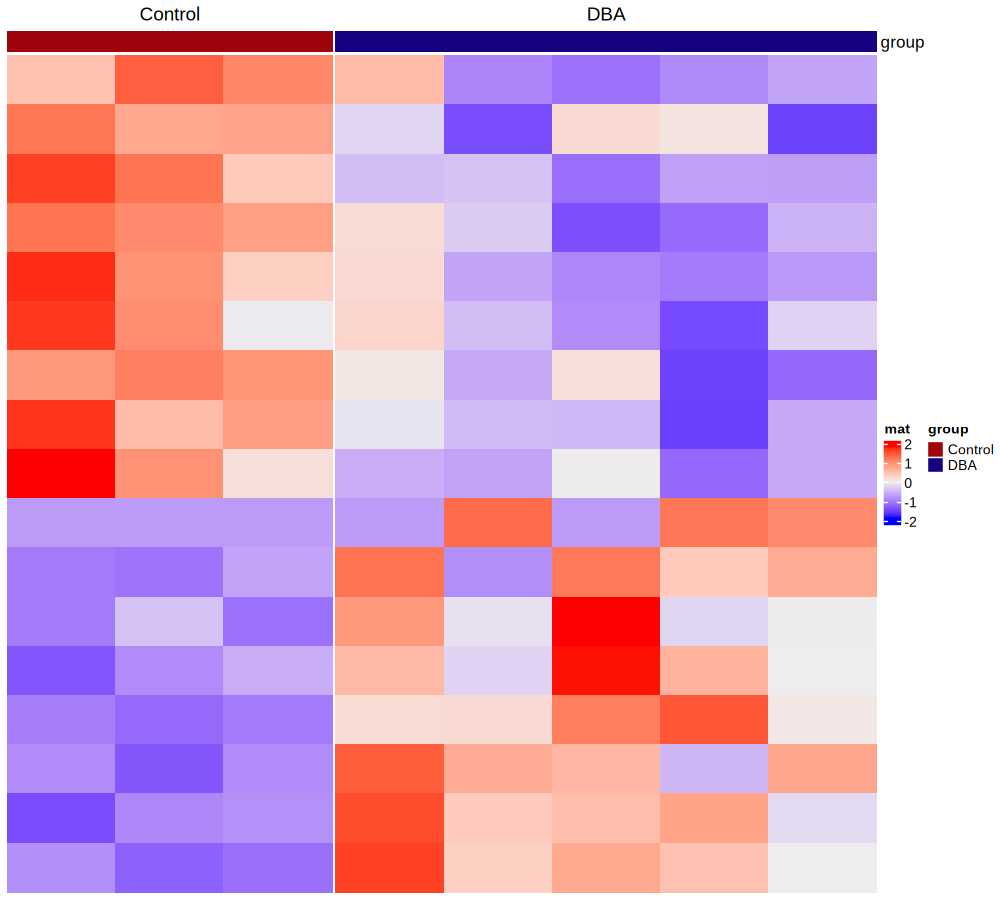

In [245]:
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  #row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, #left_annotation = column_ra, 
        column_split = factor(tmp$group, levels = c('Control', 'DBA'))) 

In [232]:
# take all together for logcpm
subtype = factor(dsn_dt2$group)
subtype = relevel(subtype, ref = 'Control')

dge = DGEList(counts = tecount_combat_df[!rownames(tecount_df) %in% coding_genes, ], group = subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~  subtype)
dge = estimateDisp(dge, design)
et <- exactTest(dge)
deg = topTags(et, n = length(keep))
deg_te_dt = as.data.table(deg$table, keep.rownames = T)

logcpm_te_df = log1p(cpm(dge, normalize = T))

logcpm_te_dt = merge(as.data.table(t(logcpm_te_df), keep.rownames = T), dsn_dt2[, .(assay_sample_name, group)], by.x = 'rn', by.y = 'assay_sample_name', all.x = T)
head(logcpm_te_dt)



rn,(CATTC)n:Satellite:Satellite,(GAATG)n:Satellite:Satellite,ALR/Alpha:centr:Satellite,Alu:Alu:SINE,AluJb:Alu:SINE,AluJo:Alu:SINE,AluJr4:Alu:SINE,AluJr:Alu:SINE,AluSc5:Alu:SINE,⋯,Zaphod5b:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,hAT-1_Mam:hAT-Tag1:DNA,hAT-4b_Ther:hAT-Tip100:DNA,hAT-5_Mam:hAT-Tag1:DNA,hAT-N1_Mam:hAT-Tip100:DNA,hAT-N1a_Mam:hAT-Tip100:DNA,teucerv1_5edge:Unknown:Unknown,teucerv2_3edge:Unknown:Unknown,group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
control1,1.9417295,2.560446,5.114853,5.551968,11.00284,7.862283,7.211939,7.903772,6.097051,⋯,2.4190919,4.769472,6.108498,2.684272,5.409972,3.558738,4.524696,2.419092,4.249789,Control
control2,2.8184820,3.750126,5.718909,5.555863,10.85683,7.647072,7.105092,7.750263,6.031320,⋯,1.6669210,4.990830,6.175247,2.729124,5.074836,2.976310,4.481291,3.389088,4.832937,Control
control3,0.6968544,2.491693,5.315632,5.579527,10.89147,7.684798,7.141489,7.638829,6.125482,⋯,2.3092482,5.011298,5.991318,3.720793,5.694351,3.051572,4.495954,3.503685,4.561200,Control
control4,0.9443061,1.562445,4.692144,5.522121,11.02033,7.751823,7.228963,7.793238,5.898625,⋯,2.4846733,4.753584,6.154301,3.469054,5.403582,3.516827,4.753584,2.939676,3.726477,Control
control5,0.0000000,1.622740,5.008432,5.360980,10.91547,7.786066,7.152363,7.745840,5.940515,⋯,2.7382747,4.711867,6.095478,3.060339,5.503172,3.428305,4.683024,2.051333,3.428305,Control
control6,1.0335519,1.820408,4.403303,5.954428,11.42714,8.397441,7.735240,8.202546,6.756269,⋯,0.2300945,4.798302,5.739617,3.459075,5.012506,3.581491,4.893832,4.621454,5.528233,Control


# TEcount Heatmap

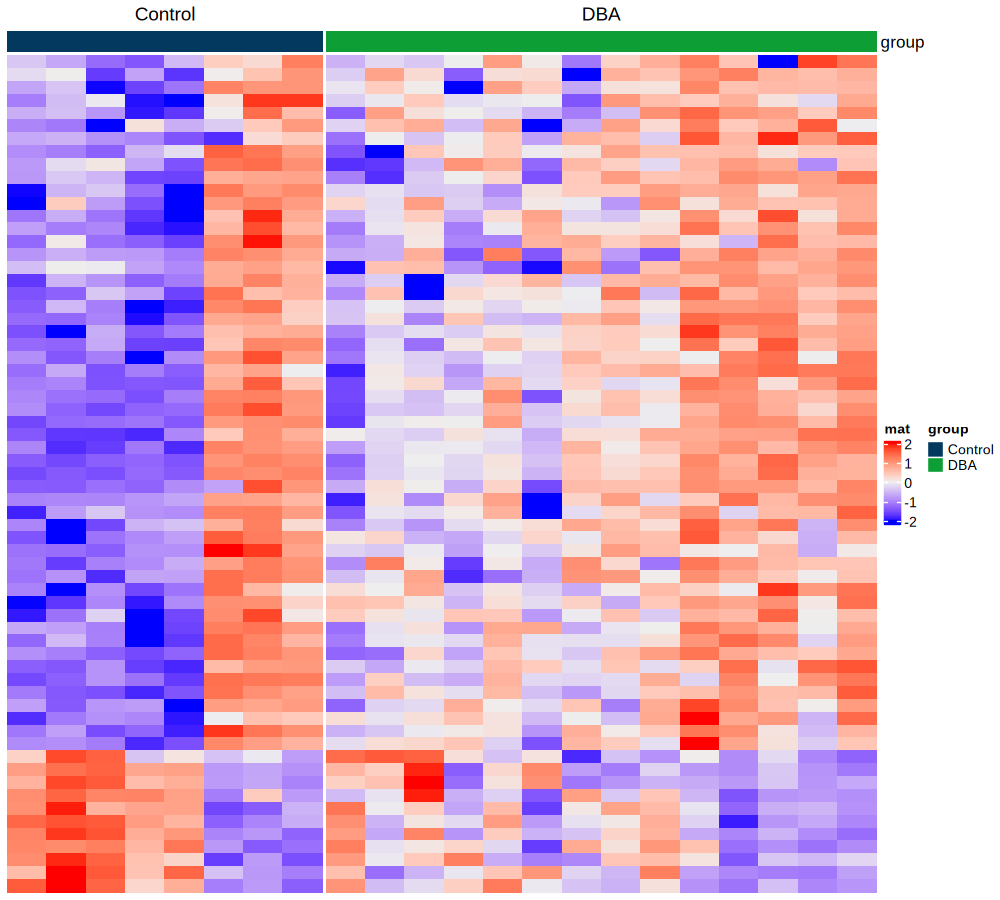

In [233]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)

plotdat = logcpm_te_df[row_sel$rn, dsn_dt2$assay_sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_dt2[, 'group', drop = F])
#column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, #left_annotation = column_ra, 
        column_split = factor(dsn_dt2$group, levels = c('Control', 'DBA')))  

# TEcount DEG

In [ ]:
deg_coding_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    mtx_ranged = mtx_coding_df[, rownames(dsn_all_df)]

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})


In [ ]:
# 

# TE DEG

In [ ]:
deg_coding_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    mtx_ranged = mtx_coding_df[, rownames(dsn_all_df)]

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})


In [ ]:
deg_te_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))
    mtx_arranged = mtx_te_df[, rownames(dsn_all_df)]

    dge = DGEList(counts=mtx_arranged, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})



# export

In [165]:
write.table(dsn_dt2, file = 'dsn_dt2.tsv')
write.table(tecount_df, file = 'tecount_df.tsv')


In [164]:
write.table(deg_te_dt, file = 'deg_te_dt.tsv')
write.table(deg_coding_dt, file = 'deg_coding_dt.tsv')


In [162]:
write.table(logcpm_coding_df, file = 'logcpm_coding_df.tsv')
write.table(logcpm_coding_dt, file = 'logcpm_coding_dt.tsv')

write.table(logcpm_te_df, file = 'logcpm_te_df.tsv')
write.table(logcpm_te_dt, file = 'logcpm_te_dt.tsv')
